In [1]:
import tensorflow as tf
import keras
print(tf.test.is_built_with_cuda())
print(tf.__version__)
print(keras.__version__)

# Make sure the GPU is available.
import tensorflow as tf

device_name = tf.test.gpu_device_name()

if device_name == '':
    print('GPU device not found. TensorFlow is using CPU.')
else:
    print('Found GPU at: {}'.format(device_name))


print(tf.test.is_gpu_available())
tf.config.list_physical_devices('GPU')

import segmentation_models_3D as sm
metrics = [sm.metrics.IOUScore(threshold=0.5)]
from skimage import io
from patchify import patchify, unpatchify
import numpy as np
from matplotlib import pyplot as plt
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import file_utilities as fu

True
2.10.0
2.10.0
Found GPU at: /device:GPU:0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
Segmentation Models: using `keras` framework.


In [2]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.layers import Activation



def Unet3D(input_shape, n_classes, conv_size=(4, 4, 4), dropout_rate_1=0.1,dropout_rate_2=0.2,dropout_rate_3=0.3,dropout_rate_4=0.5):
    x = Input(input_shape)

    conv1 = Conv3D(64, conv_size, padding='same', name = 'block1_conv1')(x)
    conv1 = BatchNormalization(name = 'block1_bn1')(conv1)   #Not in the original network. 
    conv1 = Activation("relu", name = 'block1_relu1')(conv1)
    
    conv1 = Conv3D(64, conv_size, padding='same', name = 'block1_conv2')(conv1)
    conv1 = BatchNormalization(name = 'block1_bn2')(conv1)   #Not in the original network. 
    conv1 = Activation("relu", name = 'block1_relu2')(conv1)
    
    drop1 = Dropout(dropout_rate_1, name = 'block1_drop')(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2), name = 'block1_pool')(drop1)

    conv2 = Conv3D(128, conv_size, padding='same', name = 'block2_conv1')(pool1)
    conv2 = BatchNormalization(name = 'block2_bn1')(conv2)   #Not in the original network. 
    conv2 = Activation("relu",  name = 'block2_relu1')(conv2)
    conv2 = Conv3D(128,conv_size, padding='same',  name = 'block2_conv2')(conv2)
    conv2 = BatchNormalization( name = 'block2_bn2')(conv2)   #Not in the original network. 
    conv2 = Activation("relu",  name = 'block2_relu2')(conv2)
    drop2 = Dropout(dropout_rate_1, name = 'block2_drop')(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2),  name = 'block2_pool')(drop2)

    conv3 = Conv3D(256, conv_size, padding='same', name = 'block3_conv1')(pool2)
    conv3 = BatchNormalization(name = 'block3_bn1')(conv3)   #Not in the original network. 
    conv3 = Activation("relu", name = 'block3_relu1')(conv3)
    conv3 = Conv3D(256, conv_size, padding='same', name = 'block3_conv2')(conv3)
    conv3 = BatchNormalization( name = 'block3_bn2')(conv3)   #Not in the original network. 
    conv3 = Activation("relu", name = 'block3_relu2')(conv3)
    drop3 = Dropout(dropout_rate_2, name = 'block3_drop')(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2), name = 'block3_pool')(drop3)

    conv4 = Conv3D(512, conv_size, padding='same', name = 'block4_conv1')(pool3)
    conv4 = BatchNormalization( name = 'block4_bn1')(conv4)   #Not in the original network. 
    conv4 = Activation("relu", name = 'block4_relu1')(conv4)
    conv4 = Conv3D(512, conv_size, padding='same', name = 'block4_conv2')(conv4)
    conv4 = BatchNormalization(name = 'block4_bn2')(conv4)   #Not in the original network. 
    conv4 = Activation("relu", name = 'block4_relu2')(conv4)
    drop4 = Dropout(dropout_rate_2, name = 'block4_drop')(conv4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2), name = 'block4_pool')(drop4)

    conv5 = Conv3D(1024, conv_size, padding='same', name = 'block5_conv1')(pool4)
    conv5 = BatchNormalization(name = 'block5_bn1')(conv5)   #Not in the original network. 
    conv5 = Activation("relu", name = 'block5_relu1')(conv5)
    conv5 = Conv3D(1024, conv_size, padding='same', name = 'block5_conv2')(conv5)
    conv5 = BatchNormalization(name = 'block5_bn2')(conv5)   #Not in the original network. 
    conv5 = Activation("relu", name = 'block5_relu2')(conv5)
    drop5 = Dropout(dropout_rate_3, name = 'block5_drop')(conv5)
    pool5 = MaxPooling3D(pool_size=(2, 2, 2), name = 'block5_pool')(drop5)

    # middle
    conv6 = Conv3D(2048, conv_size, padding='same', name ='center_block1_conv' )(pool5)
    conv6 = BatchNormalization(name ='center_block1_bn')(conv6)   #Not in the original network. 
    conv6 = Activation("relu", name ='center_block1_relu')(conv6)
    conv6 = Conv3D(2048, conv_size, padding='same', name ='center_block2_conv')(conv6)
    conv6 = BatchNormalization(name ='center_block2_bn')(conv6)   #Not in the original network. 
    conv6 = Activation("relu", name ='center_block2_relu')(conv6)
    drop6 = Dropout(dropout_rate_4, name = 'center_block_drop')(conv6)


    up7 = Conv3DTranspose(2048, (2, 2, 2), strides= (2, 2, 2), padding="same",  name = 'decoder_stage0_upsampling')(drop6)
    #up7 = UpSampling3D(size = (2, 2, 2), name = 'decoder_stage0_upsampling')(drop6)
    merge7 = concatenate([up7, drop5], name='decoder_stage0_concat', axis=4)
    
    conv7 = Conv3D(1024,  conv_size, padding='same', name = 'decoder_stage0a_conv')(merge7)
    conv7 = BatchNormalization(name = 'decoder_stage0a_bn')(conv7)   #Not in the original network. 
    conv7 = Activation("relu", name = 'decoder_stage0a_relu')(conv7)
    conv7 = Conv3D(1024,  conv_size, padding='same', name = 'decoder_stage0b_conv')(conv7)
    conv7 = BatchNormalization(name = 'decoder_stage0b_bn')(conv7)   #Not in the original network. 
    conv7 = Activation("relu", name = 'decoder_stage0b_relu')(conv7)
    drop7 = Dropout(dropout_rate_3, name = 'block7_drop')(conv7)

    up8 = Conv3DTranspose(1024, (2, 2, 2), strides= (2, 2, 2), padding="same")(drop7)
    #up8 = UpSampling3D(size = (2, 2, 2), name = 'decoder_stage1_upsampling')(conv7)
    merge8 = concatenate([up8, drop4], name='decoder_stage1_concat', axis=4)
    
    conv8 = Conv3D(512,  conv_size, padding='same', name = 'decoder_stage1a_conv')(merge8)
    conv8 = BatchNormalization(name = 'decoder_stage1a_bn')(conv8)   #Not in the original network. 
    conv8 = Activation("relu", name = 'decoder_stage1a_relu')(conv8)
    conv8 = Conv3D(512, conv_size, padding='same', name = 'decoder_stage1b_conv')(conv8)
    conv8 = BatchNormalization(name = 'decoder_stage1b_bn')(conv8)   #Not in the original network. 
    conv8 = Activation("relu", name = 'decoder_stage1b_relu')(conv8)
    drop8 = Dropout(dropout_rate_2, name = 'block8_drop')(conv8)
    
    up9 = Conv3DTranspose(512, (2, 2, 2), strides=  (2, 2, 2), padding="same")(drop8)
    #up9 = UpSampling3D(size = (2, 2, 2), name = 'decoder_stage2_upsampling')(conv8)
    merge9 = concatenate([up9, drop3], name='decoder_stage2_concat', axis=4)

    conv9 = Conv3D(256,  conv_size, padding='same', name = 'decoder_stage2a_conv')(merge9)
    conv9 = BatchNormalization(name = 'decoder_stage2a_bn')(conv9)   #Not in the original network. 
    conv9 = Activation("relu", name = 'decoder_stage2a_relu')(conv9)
    conv9 = Conv3D(256,  conv_size, padding='same', name = 'decoder_stage2b_conv')(conv9)
    conv9 = BatchNormalization(name = 'decoder_stage2b_bn')(conv9)   #Not in the original network. 
    conv9 = Activation("relu", name = 'decoder_stage2b_relu')(conv9)
    drop9 = Dropout(dropout_rate_2, name = 'block9_drop')(conv9)
    
    up10 = Conv3DTranspose(256, (2, 2, 2), strides=  (2, 2, 2), padding="same")(drop9)
    #up10 = UpSampling3D(size = (2, 2, 2), name = 'decoder_stage3_upsampling')(conv9)
    merge10 = concatenate([up10, drop2], name='decoder_stage3_concat', axis=4)

    conv10 = Conv3D(128,conv_size, padding='same', name = 'decoder_stage3a_conv')(merge10)
    conv10 = BatchNormalization(name = 'decoder_stage3a_bn')(conv10)   #Not in the original network. 
    conv10 = Activation("relu", name = 'decoder_stage3a_relu')(conv10)
    conv10 = Conv3D(128, conv_size, padding='same', name = 'decoder_stage3b_conv')(conv10)
    conv10 = BatchNormalization(name = 'decoder_stage3b_bn')(conv10)   #Not in the original network. 
    conv10 = Activation("relu", name = 'decoder_stage3b_relu')(conv10)
    drop10 = Dropout(dropout_rate_1, name = 'block10_drop')(conv10)

    up11 = Conv3DTranspose(128, (2, 2, 2), strides=  (2, 2, 2), padding="same")(drop10)
    #up11 = Conv3DTranspose UpSampling3D(size = (2, 2, 2), name = 'decoder_stage4_upsampling')(conv10)
    merge11 = concatenate([up11, drop1], name = 'decoder_stage4_concat', axis=4)
    
    conv11 = Conv3D(64, conv_size, padding='same', name='decoder_stage4a_conv')(merge11)
    conv11 = BatchNormalization(name='decoder_stage4a_bn')(conv11)   #Not in the original network. 
    conv11 = Activation("relu", name='decoder_stage4a_relu')(conv11)
    conv11 = Conv3D(64, conv_size, padding='same', name='decoder_stage4b_conv')(conv11)
    conv11 = BatchNormalization(name='decoder_stage4b_bn')(conv11)   #Not in the original network. 
    conv11 = Activation("relu", name='decoder_stage4b_relu')(conv11)
    drop11 = Dropout(dropout_rate_1, name = 'block11_drop')(conv11)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv3D(n_classes, 1, padding="same", activation=activation, name='final_conv')(drop11)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs=x, outputs=outputs, name="3D-UNet")

    return model


In [3]:
import numpy as np
train_img = np.load('./train_img.npy')
train_mask = np.load('./train_mask.npy')

train_mask.shape

(1024, 32, 64, 64, 1)

In [4]:
import numpy as np

# Assuming train_mask is a numpy array of shape (num_samples, height, width)
# where num_samples is the number of samples
filtered_train_img = []
filtered_train_mask = []

for i in range(train_mask.shape[0]):
    unique_values = np.unique(train_mask[i])
    if len(unique_values) > 1:
        filtered_train_img.append(train_img[i])
        filtered_train_mask.append(train_mask[i])

filtered_train_mask = np.array(filtered_train_mask)
filtered_train_img = np.array(filtered_train_img)


In [52]:
n_classes=3# background, border, axons
from keras.utils import to_categorical

train_mask_cat = to_categorical(filtered_train_mask, num_classes=n_classes)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(filtered_train_img, train_mask_cat, test_size = 0.1, random_state = 0)
np.save('./X_train.npy', X_train)
np.save('./X_test.npy', X_test)
np.save('./y_train.npy', y_train)
np.save('./y_test.npy', y_test)


(1024, 32, 64, 64, 3) (1024, 32, 64, 64, 1)
735


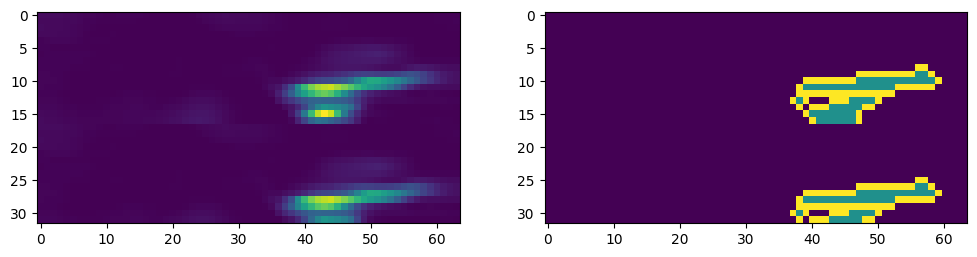

In [19]:
import numpy as np
train_img = np.load('./train_img.npy')
train_mask = np.load('./train_mask.npy')

#Sanity check, view few mages
import random
import numpy as np
print(train_img.shape, train_mask.shape)
image_number = random.randint(0, len(train_img))
print(image_number)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(train_img[image_number,:,:,28,1])
plt.subplot(122)
plt.imshow(train_mask[image_number,:,:,28,0])
plt.show()

In [25]:
n_classes=3# background, border, axons
from keras.utils import to_categorical

train_mask_cat = to_categorical(train_mask, num_classes=n_classes)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_img, train_mask_cat, test_size = 0.1, random_state = 0)


In [3]:
X_train = np.load('./X_train.npy')
X_test = np.load('./X_test.npy')
y_train = np.load('./y_train.npy')
y_test = np.load('./y_test.npy')


(604, 32, 64, 64, 3) (604, 32, 64, 64, 3)
140


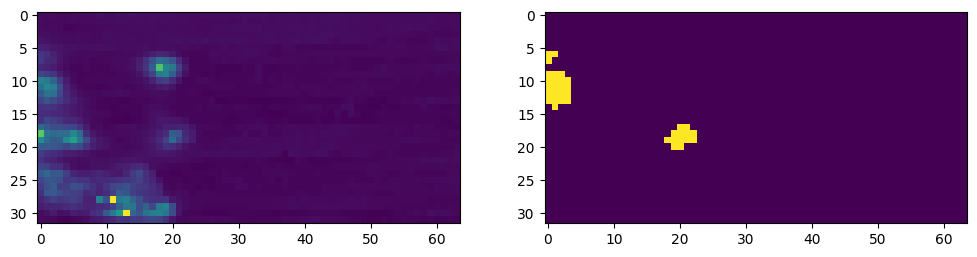

In [6]:
#Sanity check, view few mages
import random
import numpy as np
print(X_train_prep.shape, y_train.shape)
image_number = random.randint(0, len(X_train_prep))
print(image_number)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train_prep[image_number,:,:,28,1])
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,28,1])
plt.show()

In [7]:
LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.333, 0.333, 0.333])) #优点：对于不平衡的数据集和像素级别的分割任务效果较好，能够更好地处理类别间的不平衡。缺点：对噪声敏感，容易受到边缘效应的影响。
focal_loss = sm.losses.CategoricalFocalLoss()#优点：能够解决类别不平衡问题，通过调节alpha和gamma参数可以进一步调整损失函数的重点。缺点：需要调节额外的参数，可能需要进行一定的调参工作。
#jaccard_loss = sm.losses.JaccardLoss() #优点：度量了预测和标签之间的相似度，对于不平衡的数据集效果较好。缺点：对于像素级别的分割任务可能存在不连续性，需要额外处理。

total_loss = dice_loss + (1 * focal_loss)


# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5)]

In [8]:
model = Unet3D(( 32, 64, 64, 3), n_classes=3)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

softmax
Model: "3D-UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 64, 64,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv3D)          (None, 32, 64, 64,   12352       ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 block1_bn1 (BatchNormalization  (None, 32, 64, 64,   256        ['block1_conv1[0][0]']           
 )                              64)                                                 

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
#early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights = False)
model_checkpoint = ModelCheckpoint('./best_model.h5', monitor='val_loss', save_best_only=True)

callbacks=[#early_stopping,
           model_checkpoint,
                  CSVLogger('./history_au.csv'),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)
          ]

In [10]:
#Fit the model
history=model.fit(X_train_prep, 
                  y_train,
                  batch_size=2, 
                  epochs=150,
                  validation_data=(X_test_prep,y_test),
                  callbacks=callbacks)

Epoch 1/150
302/302 [==============================] - 77s 237ms/step - loss: 0.8909 - iou_score: 0.5000 - val_loss: 0.8880 - val_iou_score: 0.5055 - lr: 1.0000e-04
Epoch 2/150
302/302 [==============================] - 71s 236ms/step - loss: 0.8634 - iou_score: 0.5570 - val_loss: 0.8636 - val_iou_score: 0.5170 - lr: 1.0000e-04
Epoch 3/150
302/302 [==============================] - 71s 236ms/step - loss: 0.8445 - iou_score: 0.5686 - val_loss: 0.8445 - val_iou_score: 0.5494 - lr: 1.0000e-04
Epoch 4/150
302/302 [==============================] - 72s 238ms/step - loss: 0.8273 - iou_score: 0.5822 - val_loss: 0.8342 - val_iou_score: 0.5345 - lr: 1.0000e-04
Epoch 5/150
302/302 [==============================] - 71s 236ms/step - loss: 0.8143 - iou_score: 0.5883 - val_loss: 0.8244 - val_iou_score: 0.5394 - lr: 1.0000e-04
Epoch 6/150
302/302 [==============================] - 70s 231ms/step - loss: 0.8029 - iou_score: 0.5986 - val_loss: 0.8254 - val_iou_score: 0.5203 - lr: 1.0000e-04
Epoch 7/15

   epoch  iou_score      loss  val_iou_score  val_loss
0      0   0.500007  0.890927       0.505482  0.887958
1      1   0.557007  0.863355       0.517035  0.863612
2      2   0.568624  0.844533       0.549395  0.844512
3      3   0.582186  0.827292       0.534537  0.834174
4      4   0.588270  0.814287       0.539394  0.824393


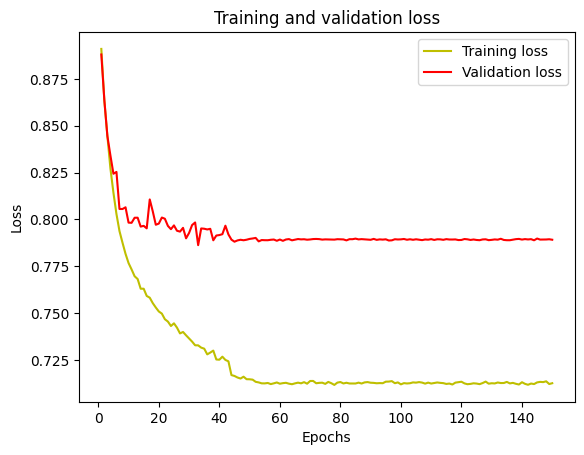

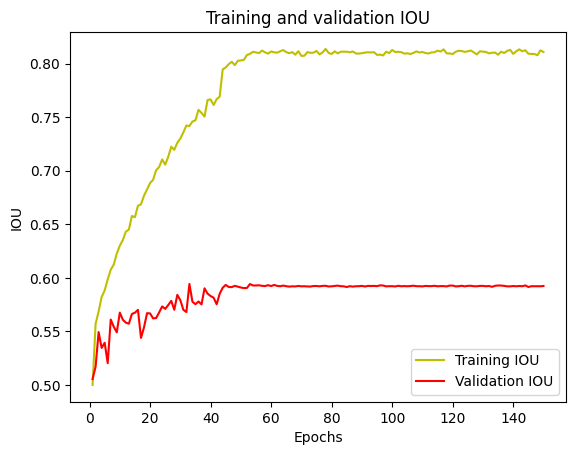

In [11]:
import pandas as pd
from matplotlib import pyplot as plt

# 读取 CSV 文件
history_df = pd.read_csv('./history_au.csv')

# 查看数据结构
print(history_df.head())

# 绘制训练和验证损失
loss = history_df['loss']
val_loss = history_df['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('./loss_plot.png', bbox_inches='tight')  # Save the plot as PNG image
plt.show()

# 绘制训练和验证 IOU
iou = history_df['iou_score']
val_iou = history_df['val_iou_score']
plt.plot(epochs, iou, 'y', label='Training IOU')
plt.plot(epochs, val_iou, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.savefig('./iou_plot.png', bbox_inches='tight')  # Save the plot as PNG image
plt.show()


In [8]:
import tensorflow as tf
import keras
print(tf.test.is_built_with_cuda())
print(tf.__version__)
print(keras.__version__)

# Make sure the GPU is available.
import tensorflow as tf

device_name = tf.test.gpu_device_name()

if device_name == '':
    print('GPU device not found. TensorFlow is using CPU.')
else:
    print('Found GPU at: {}'.format(device_name))


print(tf.test.is_gpu_available())
tf.config.list_physical_devices('GPU')

import segmentation_models_3D as sm
from skimage import io
from patchify import patchify, unpatchify
import numpy as np
from matplotlib import pyplot as plt
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import file_utilities as fu

True
2.10.0
2.10.0
Found GPU at: /device:GPU:0
True


In [2]:
X_train = np.load('./X_train.npy')
X_test = np.load('./X_test.npy')
y_train = np.load('./y_train.npy')
y_test = np.load('./y_test.npy')


(604, 32, 64, 64, 3) (604, 32, 64, 64, 3)
35


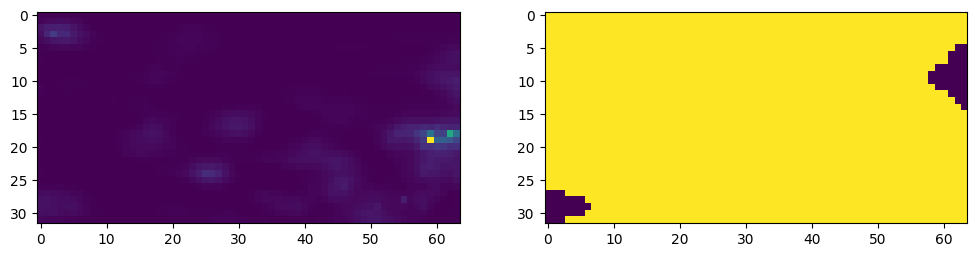

In [12]:
#Sanity check, view few mages
import random
import numpy as np
print(X_train.shape, y_train.shape)
image_number = random.randint(0, len(X_train))
print(image_number)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,28,1])
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,28,0])
plt.show()

In [9]:
LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.333, 0.333, 0.333])) #优点：对于不平衡的数据集和像素级别的分割任务效果较好，能够更好地处理类别间的不平衡。缺点：对噪声敏感，容易受到边缘效应的影响。
focal_loss = sm.losses.CategoricalFocalLoss()#优点：能够解决类别不平衡问题，通过调节alpha和gamma参数可以进一步调整损失函数的重点。缺点：需要调节额外的参数，可能需要进行一定的调参工作。
#jaccard_loss = sm.losses.JaccardLoss() #优点：度量了预测和标签之间的相似度，对于不平衡的数据集效果较好。缺点：对于像素级别的分割任务可能存在不连续性，需要额外处理。

total_loss = dice_loss + (1 * focal_loss)


# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5)]

In [11]:
#Load the pretrained model for testing and predictions. 
from keras.models import load_model
def dice_loss_plus_1focal_loss(y_true, y_pred):
    total_loss
    pass
def iou_score(y_true, y_pred):
    metrics    
    pass
model = load_model('./best_model.h5',custom_objects={'dice_loss_plus_1focal_loss': dice_loss_plus_1focal_loss, 'iou_score': iou_score})
model.compile(optimizer=optim, loss=total_loss, metrics=metrics)

#If you load a different model do not forget to preprocess accordingly. 

In [31]:
from keras.models import load_model
#Load the pretrained model for testing and predictions. 
model = load_model('./best_model.h5',compile = False)


3/3 [==============================] - 5s 2s/step
[[0.96081701 0.01899802 0.02018497]
 [0.24926185 0.7071009  0.04363725]
 [0.37328417 0.24067115 0.38604468]]


<Figure size 800x600 with 0 Axes>

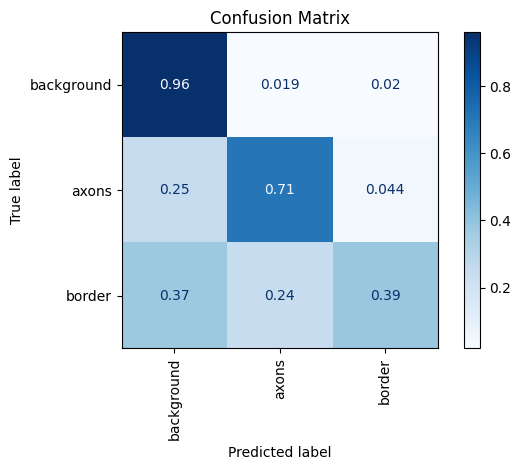

              precision    recall  f1-score   support

           0       0.98      0.96      0.97   8298600
           1       0.54      0.71      0.61    360701
           2       0.35      0.39      0.37    253595

    accuracy                           0.93   8912896
   macro avg       0.62      0.68      0.65   8912896
weighted avg       0.94      0.93      0.94   8912896

IoU: 0.53474176


In [13]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from keras.metrics import MeanIoU
import numpy as np

# 假設 predictions 是模型的預測結果
predictions = model.predict(X_test_prep)
predictions = np.argmax(predictions, axis=-1)  # 從概率到類別索引

# 真實標籤需要與預測相同的處理
true_labels = np.argmax(y_test, axis=-1)
plt.figure(figsize=(8, 6))
# 混淆矩陣
class_labels = ['background', 'axons', 'border']
cm = confusion_matrix(true_labels.flatten(), predictions.flatten(), normalize="true")
print(cm)
ConfusionMatrixDisplay(cm, display_labels = class_labels).plot(
    include_values=True, cmap=plt.cm.Blues, xticks_rotation="vertical"
)
plt.title("Confusion Matrix")
plt.savefig('./confusion_matrix.png', bbox_inches='tight')  # Save the plot as PNG image
plt.tight_layout()
plt.show()

# 分類報告
print(classification_report(true_labels.flatten(), predictions.flatten()))

# 計算IoU
num_classes = len(np.unique(true_labels))  # 假設的類別數量
iou = MeanIoU(num_classes=num_classes)
iou.update_state(true_labels, predictions)
print("IoU:", iou.result().numpy())
